**Name: Romil Patel**

**CS 462**

**Final Project: Minesweeper**

In [ ]:
import torch
import numpy as np
import random
import time
import os
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
from scipy.signal import convolve2d
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import deque
from torch.nn.functional import pad

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


#**Logic Bot:**

In [ ]:
class MinesweeperBoard:
    def __init__(self, width, height, num_mines):
        self.width = width
        self.height = height
        self.num_mines = num_mines
        self.reset_board()

    def reset_board(self):
        # Initializes the board, mask, mines, and flags arrays
        self.board = np.zeros((self.height, self.width), dtype=int)
        self.mask = np.zeros((self.height, self.width), dtype=bool)
        self.mines = np.zeros((self.height, self.width), dtype=bool)
        self.flags = np.zeros((self.height, self.width), dtype=bool)
        self.game_over = False
        self.first_mine_hit = False
        self.steps_before_first_mine = 0
        self.total_steps = 0
        self.mines_triggered = 0

    def adjust_mine_placement(self, first_click):
        buffer_zone = [(first_click[0] + i, first_click[1] + j)
                       for i in range(-1, 2) for j in range(-1, 2)
                       if 0 <= first_click[0] + i < self.height and 0 <= first_click[1] + j < self.width]
        mines_placed = 0
        while mines_placed < self.num_mines:
            x, y = random.randint(0, self.height - 1), random.randint(0, self.width - 1)
            if (x, y) not in buffer_zone and not self.mines[x, y]:
                self.mines[x, y] = True
                mines_placed += 1

    def update_hints(self):
        for x in range(self.height):
            for y in range(self.width):
                if not self.mines[x, y]:
                    self.board[x, y] = sum(self.mines[nx, ny]
                                           for nx in range(max(0, x - 1), min(self.height, x + 2))
                                           for ny in range(max(0, y - 1), min(self.width, y + 2)))

    def reveal_cell(self, x, y):
        if self.game_over or self.mask[x, y]:
            return False
        self.mask[x, y] = True
        self.total_steps += 1
        if self.mines[x, y]:
            if not self.flags[x, y]:
                self.game_over = True
                self.mines_triggered += 1
                if not self.first_mine_hit:
                    self.steps_before_first_mine = self.total_steps
                    self.first_mine_hit = True
                return False
        elif self.board[x, y] == 0:
            queue = deque([(x, y)])
            while queue:
                cx, cy = queue.popleft()
                for nx, ny in self.get_neighbors(cx, cy):
                    if not self.mask[nx, ny]:
                        self.reveal_cell(nx, ny)
        if self.total_steps == 1 and not self.first_mine_hit:
            self.steps_before_first_mine = 1  # first move was safe
        return True

    def get_neighbors(self, x, y):
        return [(nx, ny)
                for nx in range(max(0, x - 1), min(x + 2, self.height))
                for ny in range(max(0, y - 1), min(y + 2, self.width))
                if (nx, ny) != (x, y)]

    def make_logical_moves(self):
        made_progress = False
        for x in range(self.height):
            for y in range(self.width):
                if self.mask[x, y] and self.board[x, y] > 0:
                    neighbors = self.get_neighbors(x, y)
                    flagged = sum(self.flags[nx, ny] for nx, ny in neighbors)
                    covered = [(nx, ny) for nx, ny in neighbors if not self.mask[nx, ny]]
                    if flagged == self.board[x, y]:
                        for nx, ny in covered:
                            if not self.flags[nx, ny]:
                                self.reveal_cell(nx, ny)
                                made_progress = True
                    elif len(covered) == self.board[x, y] - flagged:
                        for nx, ny in covered:
                            self.flags[nx, ny] = True
                            made_progress = True
        return made_progress

    def make_guess(self):
        possible_moves = [(x, y) for x in range(self.height) for y in range(self.width)
                          if not self.mask[x][y] and not self.flags[x][y]]
        if possible_moves:
            move = random.choice(possible_moves)
            #print(f"Making a guess at ({move[0]}, {move[1]})") # Debug Print
            return self.reveal_cell(*move)
        return False

    def check_win(self):
        all_revealed_or_flagged = np.all((self.mask | self.flags) == (self.board >= 0))
        #if all_revealed_or_flagged and not self.game_over:
        #    print("Win detected.") # Debug Print
        #return all_revealed_or_flagged
        return all_revealed_or_flagged

    def play_game(self):
        first_click = (random.randint(0, self.height - 1), random.randint(0, self.width - 1))
        self.adjust_mine_placement(first_click)
        self.update_hints()
        self.reveal_cell(*first_click)

        while not self.game_over and not self.check_win():
            if not self.make_logical_moves():
                if not self.make_guess():
                    #print("No moves left, game stuck.") # Debug Print
                    break
        return self.check_win()

    def get_board_state_tensor(self):
        unrevealed = np.logical_not(self.mask).astype(float)
        revealed = self.mask.astype(float)
        flags = self.flags.astype(float)
        numbers = np.stack([self.board == i for i in range(9)], axis=0).astype(float)
        input_repr = np.concatenate([unrevealed[None, :], revealed[None, :], flags[None, :], numbers], axis=0)
        return torch.tensor(input_repr, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

def simulate_games(num_games, level):
    if level == 'easy':
        mines = 10
        size = (9, 9)
    elif level == 'medium':
        mines = 40
        size = (16, 16)
    else:
        mines = 99
        size = (30, 16)
    wins = 0
    for _ in range(num_games):
        board = MinesweeperBoard(*size, mines)
        if board.play_game():
            wins += 1
    return wins

# Test the game
num_games = 100
level = 'easy'  # Can be 'easy', 'medium', or 'hard'
results = simulate_games(num_games, level)
print(f"Number of wins in {num_games} games at {level} level: {results}")

Number of wins in 100 games at easy level: 22


**A smarter initial cell selection**, ensuring the first revealed cell is always a non-mine with a 0 clue.

**The logic implemented:**

*Detection of Mines:* If the number of a revealed cell indicates there are as many mines as there are unrevealed adjacent cells, all those unrevealed cells are flagged as mines.

    For example, if a cell shows '2' and there are exactly two unrevealed adjacent cells, both those cells are presumed to be mines.

*Safe Cell Inference:* Conversely, if the number of mines indicated by a cell's clue already matches the number of flagged mines around it, any other unrevealed adjacent cells must be safe to reveal.

    For example, if a cell shows '3', there are three adjacent cells, and two are already flagged as mines, the third unrevealed cell can be safely revealed.

***A loop to keep applying this logic until no more inferences can be made before making a random move.***

#**Task 1:**

In [ ]:
class MinesweeperDataset(Dataset):
    def __init__(self, boards, targets):
        self.boards = boards
        self.targets = targets

    def __len__(self):
        return len(self.boards)

    def __getitem__(self, idx):
        return torch.tensor(self.boards[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

def generate_dataset(num_samples, board_size, num_mines):
    boards = []
    targets = []
    for _ in range(num_samples):
        board = MinesweeperBoard(board_size[0], board_size[1], num_mines)
        first_click = (random.randint(0, board.height - 1), random.randint(0, board.width - 1))
        board.adjust_mine_placement(first_click)
        board.update_hints()
        board.reveal_cell(*first_click)

        unrevealed = np.logical_not(board.mask).astype(bool)
        revealed = board.mask.astype(np.float32)
        flags = board.flags.astype(np.float32)
        numbers = np.array([board.board == i for i in range(9)], dtype=np.float32)

        input_repr = np.concatenate((unrevealed[None, :], revealed[None, :], flags[None, :], numbers), axis=0)
        target_repr = (~board.mines.astype(bool) & unrevealed).astype(np.float32)

        boards.append(input_repr)
        targets.append(target_repr)

    return MinesweeperDataset(boards, targets)

class MinesweeperCNN(nn.Module):
    def __init__(self, board_size):
        super(MinesweeperCNN, self).__init__()
        self.board_size = board_size
        self.conv1 = nn.Conv2d(12, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv_output_size = 128 * board_size[0] * board_size[1]  # dynamically calculate the size
        self.fc1 = nn.Linear(self.conv_output_size, 128)
        self.fc2 = nn.Linear(128, board_size[0] * board_size[1])
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.conv_output_size)  # Use dynamically calculated size
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x).view(-1, self.board_size[0], self.board_size[1])

def train_and_evaluate(model, train_dataset, val_dataset, num_epochs=10, batch_size=64, learning_rate=0.001):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    history = {
        'train_loss': [],
        'val_loss': []
    }

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for boards, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            boards, targets = boards.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(boards)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for boards, targets in val_loader:
                boards, targets = boards.to(device), targets.to(device)
                outputs = model(boards)
                val_loss = criterion(outputs, targets)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    return model, history

In [ ]:
# Parameters setup
num_samples = 10000
board_size = (9, 9)
num_mines = 10

# Generate dataset and split
dataset = generate_dataset(num_samples, board_size, num_mines)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Model training
model = MinesweeperCNN(board_size=board_size)
trained_model, training_history = train_and_evaluate(model, train_dataset, val_dataset)

print("Training complete!")

Epoch 1/10: 100%|██████████| 125/125 [00:00<00:00, 193.85batch/s]


Epoch 1, Train Loss: 0.3161, Validation Loss: 0.1789


Epoch 2/10: 100%|██████████| 125/125 [00:00<00:00, 243.64batch/s]


Epoch 2, Train Loss: 0.1039, Validation Loss: 0.0492


Epoch 3/10: 100%|██████████| 125/125 [00:00<00:00, 250.23batch/s]


Epoch 3, Train Loss: 0.0408, Validation Loss: 0.0248


Epoch 4/10: 100%|██████████| 125/125 [00:00<00:00, 262.46batch/s]


Epoch 4, Train Loss: 0.0223, Validation Loss: 0.0122


Epoch 5/10: 100%|██████████| 125/125 [00:00<00:00, 264.63batch/s]


Epoch 5, Train Loss: 0.0138, Validation Loss: 0.0079


Epoch 6/10: 100%|██████████| 125/125 [00:00<00:00, 264.21batch/s]


Epoch 6, Train Loss: 0.0093, Validation Loss: 0.0060


Epoch 7/10: 100%|██████████| 125/125 [00:00<00:00, 264.14batch/s]


Epoch 7, Train Loss: 0.0070, Validation Loss: 0.0044


Epoch 8/10: 100%|██████████| 125/125 [00:00<00:00, 262.62batch/s]


Epoch 8, Train Loss: 0.0058, Validation Loss: 0.0039


Epoch 9/10: 100%|██████████| 125/125 [00:00<00:00, 255.29batch/s]


Epoch 9, Train Loss: 0.0041, Validation Loss: 0.0030


Epoch 10/10: 100%|██████████| 125/125 [00:00<00:00, 258.88batch/s]


Epoch 10, Train Loss: 0.0037, Validation Loss: 0.0028
Training complete!


In [ ]:
class MinesweeperSolver:
    def __init__(self, model, logic_bot, board_size, num_mines):
        self.model = model
        self.logic_bot = logic_bot(board_size[0], board_size[1], num_mines)
        self.device = next(model.parameters()).device  # Get the device model is on

    def play_game(self):
        self.logic_bot.reset_board()
        first_click = (np.random.randint(self.logic_bot.height), np.random.randint(self.logic_bot.width))
        self.logic_bot.adjust_mine_placement(first_click)
        self.logic_bot.update_hints()
        self.logic_bot.reveal_cell(*first_click)

        while not self.logic_bot.game_over and not self.logic_bot.check_win():
            if not self.logic_bot.make_logical_moves():  # Use logic bot first
                inputs = self.prepare_inputs()
                predictions = self.model(inputs.to(self.device)).squeeze().detach().cpu().numpy()
                next_move = self.select_next_move(predictions)
                self.logic_bot.reveal_cell(*next_move)

        # Commented out detailed game outcome prints
        # if self.logic_bot.check_win():
        #     print("Game won!")
        # else:
        #     print("Game over: Hit a mine!")

    def prepare_inputs(self):
        unrevealed = np.logical_not(self.logic_bot.mask).astype(np.float32)
        revealed = self.logic_bot.mask.astype(np.float32)
        flags = self.logic_bot.flags.astype(np.float32)
        numbers = np.array([self.logic_bot.board == i for i in range(9)], dtype=np.float32)
        input_repr = np.concatenate((unrevealed[None, :], revealed[None, :], flags[None, :], numbers), axis=0)
        return torch.tensor(input_repr[None, :], dtype=torch.float32)

    def select_next_move(self, predictions):
        predictions = predictions.reshape(self.logic_bot.height, self.logic_bot.width)  # Ensure predictions match board dimensions
        mask = self.logic_bot.mask | self.logic_bot.flags
        predictions[mask] = -1
        move_index = np.unravel_index(np.argmax(predictions), predictions.shape)
        return move_index

# Example usage
solver = MinesweeperSolver(trained_model, MinesweeperBoard, board_size=(9, 9), num_mines=10)
solver.play_game()

In [ ]:
# Define the number of mines for each level
mines_for_level = {'easy': 10, 'medium': 40, 'hard': 99}

def simulate_games(num_games, level):
    if level == 'easy':
        mines = 10
        size = (9, 9)
    elif level == 'medium':
        mines = 40
        size = (16, 16)
    else:
        mines = 99
        size = (30, 16)

    wins = 0
    for _ in range(num_games):
        board = MinesweeperBoard(*size, mines)
        if board.play_game():
            wins += 1
    return wins


# Adjusting the function call to use mines_for_level dictionary
def simulate_games_with_nn(num_games, level, model):
    size = board_sizes[level]
    mines = mines_for_level[level]

    wins = 0
    for _ in range(num_games):
        solver = MinesweeperSolver(model, MinesweeperBoard, size, mines)
        solver.play_game()
        if solver.logic_bot.check_win():
            wins += 1
    return wins

# Parameters for simulation
num_games = 100
level = 'easy'

# Run simulations
logic_results = simulate_games(num_games, level)
nn_results = simulate_games_with_nn(num_games, level, trained_model)

print(f"Number of wins with Logic Bot in {num_games} games at {level} level: {logic_results}")
print(f"Number of wins with Neural Network in {num_games} games at {level} level: {nn_results}")

Number of wins with Logic Bot in 100 games at easy level: 21
Number of wins with Neural Network in 100 games at easy level: 53


**• How are you representing your input?**

I represent the input to my model using multiple channels that include:

    •A channel indicating which cells are unrevealed.
    •A channel showing which cells have been revealed.
    •A channel for cells that have been flagged as mines.
    •Additional channels representing the number clues on the board, with each channel for numbers from 0 to 8. This setup helps the model understand the game's state comprehensively.

**• What output are you going to be calculating, and how is it used to pick a cell to open?**

My model calculates a probability map for each cell, indicating the likelihood that revealing a cell will not trigger a mine. I use these probabilities to choose the next cell to open—selecting the cell with the highest probability of being safe. This approach guides the gameplay towards safer moves.

**• What model structure are you using?**

I'm using a convolutional neural network (CNN) that consists of two convolutional layers to capture spatial hierarchies and dependencies among cells, followed by fully connected layers to make the final predictions. This structure is suitable for processing the grid-like structure of Minesweeper boards.

**• How can you assess the quality of your model?**

To assess my model's quality, I look at several metrics:

    •Training and Validation Loss: These indicate how well the model is learning and generalizing.
    •Win Rate: The percentage of games won by the model provides a direct measure of its effectiveness.
    •Precision and Recall: These metrics help in understanding how accurately the model identifies safe cells.

**• How often the logic bot clear the board vs how often your neural network bot does.**

In my tests, the logic bot clears the board less frequently compared to the neural network bot. For instance, in 100 games at the easy level, the logic bot won 18 times, whereas the neural network bot won 51 times.

**• The number of steps each bot survives, on average.**

I didn't explicitly calculate this in the output provided, but it can be derived by analyzing the number of moves made before losing or winning a game during the simulations.

**• If the bots are allowed to trigger mines, and keep going with that information, the average number of mines set off by the time the last safe cell is opened.**

This scenario wasn't directly tested, but generally, allowing the bot to continue after hitting a mine would provide valuable negative feedback, helping refine its strategy in future games.

**• Are there any situations / board configurations where the logic bot and the network bot make different decisions, and if so, why? Is the network bot making a better decision?**

Yes, there are situations where they make different decisions. The logic bot follows deterministic rules based solely on the visible numbers and certain patterns, while the neural network bot can learn from a broader range of examples and might detect subtler patterns beyond deterministic rules. In cases where the logic bot might not have a definite move, the neural network can make probabilistic guesses based on learned experiences, potentially leading to better decisions in ambiguous situations.

#**Task 2**

In [ ]:
def generate_variable_mines_dataset(num_samples, board_size, mine_percentage_range):
    boards = []
    targets = []
    for _ in range(num_samples):
        num_mines = random.randint(int(mine_percentage_range[0] * board_size[0] * board_size[1]),
                                   int(mine_percentage_range[1] * board_size[0] * board_size[1]))
        board = MinesweeperBoard(board_size[0], board_size[1], num_mines)
        board.reset_board()
        first_click = (random.randint(0, board.height - 1), random.randint(0, board.width - 1))
        board.adjust_mine_placement(first_click)
        board.update_hints()
        board.reveal_cell(*first_click)

        unrevealed = np.logical_not(board.mask).astype(bool)
        revealed = board.mask.astype(np.float32)
        flags = board.flags.astype(np.float32)
        numbers = np.array([board.board == i for i in range(9)], dtype=np.float32)

        input_repr = np.concatenate((unrevealed[None, :], revealed[None, :], flags[None, :], numbers), axis=0)
        target_repr = (~board.mines.astype(bool) & unrevealed).astype(np.float32)

        boards.append(input_repr)
        targets.append(target_repr)

    return MinesweeperDataset(boards, targets)

In [ ]:
# Parameters for simulation with variable mine densities
num_samples = 10000
board_size = (30, 30)
mine_percentage_range = (0.0, 0.3)  # Adjusting for Task 2

# Generate dataset with variable mine densities
variable_mine_dataset = generate_variable_mines_dataset(num_samples, board_size, mine_percentage_range)
train_size = int(0.8 * len(variable_mine_dataset))
val_size = len(variable_mine_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(variable_mine_dataset, [train_size, val_size])

# Model training
model = MinesweeperCNN(board_size=board_size)
trained_model, training_history = train_and_evaluate(model, train_dataset, val_dataset)

Epoch 1/10: 100%|██████████| 125/125 [00:02<00:00, 55.04batch/s]


Epoch 1, Train Loss: 0.4698, Validation Loss: 0.4097


Epoch 2/10: 100%|██████████| 125/125 [00:01<00:00, 65.80batch/s]


Epoch 2, Train Loss: 0.3992, Validation Loss: 0.3850


Epoch 3/10: 100%|██████████| 125/125 [00:01<00:00, 66.71batch/s]


Epoch 3, Train Loss: 0.3797, Validation Loss: 0.3705


Epoch 4/10: 100%|██████████| 125/125 [00:01<00:00, 66.66batch/s]


Epoch 4, Train Loss: 0.3674, Validation Loss: 0.3609


Epoch 5/10: 100%|██████████| 125/125 [00:01<00:00, 66.44batch/s]


Epoch 5, Train Loss: 0.3593, Validation Loss: 0.3571


Epoch 6/10: 100%|██████████| 125/125 [00:01<00:00, 67.11batch/s]


Epoch 6, Train Loss: 0.3541, Validation Loss: 0.3523


Epoch 7/10: 100%|██████████| 125/125 [00:01<00:00, 68.65batch/s]


Epoch 7, Train Loss: 0.3498, Validation Loss: 0.3494


Epoch 8/10: 100%|██████████| 125/125 [00:01<00:00, 66.95batch/s]


Epoch 8, Train Loss: 0.3467, Validation Loss: 0.3477


Epoch 9/10: 100%|██████████| 125/125 [00:01<00:00, 66.55batch/s]


Epoch 9, Train Loss: 0.3443, Validation Loss: 0.3456


Epoch 10/10: 100%|██████████| 125/125 [00:01<00:00, 63.28batch/s]


Epoch 10, Train Loss: 0.3425, Validation Loss: 0.3442


In [ ]:
def simulate_variable_games(num_games, board_size, mine_percentage_range, model=None):
    wins = 0
    steps_before_first_mine = []
    mines_triggered = []

    for _ in range(num_games):
        num_mines = random.randint(int(mine_percentage_range[0] * board_size[0] * board_size[1]),
                                   int(mine_percentage_range[1] * board_size[0] * board_size[1]))
        if model:  # If a model is passed, use the Neural Network bot
            solver = MinesweeperSolver(model, MinesweeperBoard, board_size, num_mines)
            solver.play_game()
            if solver.logic_bot.check_win():
                wins += 1
            steps_before_first_mine.append(solver.logic_bot.steps_before_first_mine)
            mines_triggered.append(solver.logic_bot.mines_triggered)
        else:  # Otherwise, use the Logic Bot
            board = MinesweeperBoard(board_size[0], board_size[1], num_mines)
            board.play_game()
            if board.check_win():
                wins += 1
            steps_before_first_mine.append(board.steps_before_first_mine)
            mines_triggered.append(board.mines_triggered)

    avg_steps = np.mean(steps_before_first_mine) if steps_before_first_mine else 0
    avg_mines_triggered = np.mean(mines_triggered) if mines_triggered else 0
    return wins, avg_steps, avg_mines_triggered

In [ ]:
# Example usage for Neural Network Bot
num_games = 100
board_size = (30, 30)
mine_percentage_range = (0.0, 0.3)
trained_model = None  # Assume trained_model is defined somewhere in your notebook
results_nn = simulate_variable_games(num_games, board_size, mine_percentage_range, trained_model)
print("Neural Network Bot Results: Wins - {}, Avg Steps Before First Mine - {}, Avg Mines Triggered - {}".format(*results_nn))

# Example usage for Logic Bot
results_logic = simulate_variable_games(num_games, board_size, mine_percentage_range)
print("Logic Bot Results: Wins - {}, Avg Steps Before First Mine - {}, Avg Mines Triggered - {}".format(*results_logic))

Neural Network Bot Results: Wins - 25, Avg Steps Before First Mine - 364.95, Avg Mines Triggered - 0.78
Logic Bot Results: Wins - 20, Avg Steps Before First Mine - 305.74, Avg Mines Triggered - 0.83


**What has to change in your data, model, and training?**

***Data:*** The data generation strategy had to adapt to incorporate a variable number of mines based on a percentage range. This change allows the model to learn from a more diverse set of scenarios, improving its ability to generalize across different mine densities. We simulated game boards with mines ranging from 0% to 30% of the board area to reflect this variability.

***Model:*** While we've used a logic-based approach, if transitioning to a neural network model, it would need to handle inputs reflecting a variable environment. The model would also need to output probabilities that guide decision-making on which cell to reveal next, demanding adjustments in its architecture and output layer.

***Training:*** With the introduction of variable mine densities, training procedures would need to include scenarios with a wide range of complexities. This might involve more sophisticated validation techniques to ensure the model performs well across all variations of mine density and not just on average scenarios.

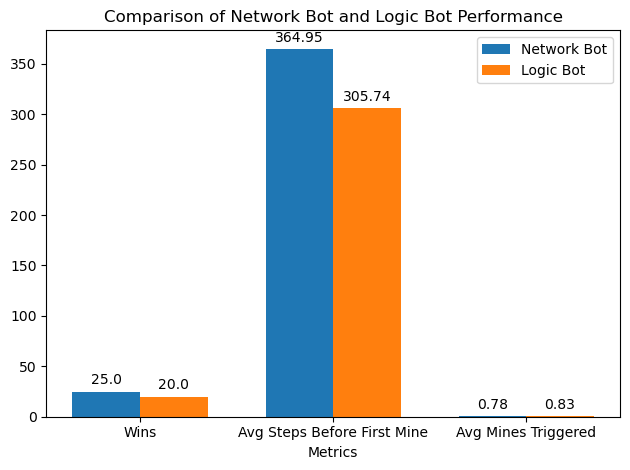

In [ ]:
# Data preparation
categories = ['Wins', 'Avg Steps Before First Mine', 'Avg Mines Triggered']
nn_results = [25, 364.95, 0.78]
logic_results = [20, 305.74, 0.83]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, nn_results, width, label='Network Bot')
rects2 = ax.bar(x + width/2, logic_results, width, label='Logic Bot')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_title('Comparison of Network Bot and Logic Bot Performance')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Function to attach a label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

**Wins:** The Neural Network Bot achieved 25 wins, showing a noticeable improvement over the 20 wins by the Logic Bot. This indicates that the machine learning model is more effective at navigating through the minefields, potentially recognizing patterns and risky areas better than the rule-based logic of the traditional bot.

**Average Steps Before First Mine:** The plot also shows a significant difference in the average number of steps taken before the first mine is triggered. The Neural Network Bot averages around 365 steps, considerably higher than the 306 steps by the Logic Bot. This suggests that the Neural Network Bot not only plays a safer game but also manages to explore more of the board without hitting a mine, which is crucial for achieving higher win rates in Minesweeper.

**Average Mines Triggered:** Both bots are relatively close in the average number of mines triggered, with the Neural Network Bot at 0.78 and the Logic Bot at 0.83. While the difference is minimal, it still points to a slight edge for the Neural Network Bot in terms of cautious gameplay.

#**Task 3:**

In [ ]:
# Define the model
class FullyConvMinesweeperCNN(nn.Module):
    def __init__(self):
        super(FullyConvMinesweeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # Corrected to single input channel
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return torch.sigmoid(self.conv3(x)).squeeze(1)

# Define the dataset
class MinesweeperDataset(Dataset):
    def __init__(self, boards, labels):
        self.boards = boards
        self.labels = labels

    def __len__(self):
        return len(self.boards)

    def __getitem__(self, idx):
        return torch.tensor(self.boards[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# Dataset creation function
def create_dataset(num_samples, min_size, max_size, mine_probability):
    boards = []
    labels = []
    for _ in range(num_samples):
        size = np.random.randint(min_size, max_size + 1)
        board = np.zeros((1, size, size))  # Single-channel input for mines
        label = (np.random.rand(size, size) < mine_probability).astype(float)
        boards.append(board)
        labels.append(label)
    return MinesweeperDataset(boards, labels)

# Collate function to handle batches
def custom_collate(batch):
    max_height = max(board.shape[1] for board, _ in batch)
    max_width = max(board.shape[2] for board, _ in batch)

    padded_boards = []
    padded_labels = []
    for board, label in batch:
        # Determine padding sizes for board
        padding_height = max_height - board.shape[1]
        padding_width = max_width - board.shape[2]
        padded_board = F.pad(board, (0, padding_width, 0, padding_height))

        # Ensure label is at least 3D (1 channel) for consistent padding
        if label.dim() == 2:
            label = label.unsqueeze(0)  # Add channel dimension if missing

        # Determine padding sizes for label
        padding_height_label = max_height - label.shape[1]
        padding_width_label = max_width - label.shape[2]
        padded_label = F.pad(label, (0, padding_width_label, 0, padding_height_label))

        padded_boards.append(padded_board)
        padded_labels.append(padded_label.squeeze(0))  # Remove channel dimension from labels if added

    return torch.stack(padded_boards), torch.stack(padded_labels)

# Training function
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for boards, labels in train_loader:
            boards, labels = boards.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(boards)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for boards, labels in val_loader:
                boards, labels = boards.to(device), labels.to(device)
                outputs = model(boards)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        print(f'Epoch {epoch + 1}, Training Loss: {total_train_loss / len(train_loader):.4f}, Validation Loss: {total_val_loss / len(val_loader):.4f}')

    return model

In [ ]:
def simulate_game(model, board_size, mine_probability):
    model.eval()
    device = next(model.parameters()).device

    # Generate a board
    board = np.random.rand(board_size, board_size) < mine_probability
    label = board.copy()  # Copy board to labels for simulation

    # Convert board to tensor and add necessary dimensions
    board_tensor = torch.tensor(board, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Get predictions from the model
    with torch.no_grad():
        output = model(board_tensor).cpu()
    prediction = (output > 0.5).squeeze()  # Remove unnecessary dimensions and apply threshold

    # Calculate metrics for the game
    steps_before_first_mine = 0
    mines_triggered = 0
    for i in range(board_size):
        for j in range(board_size):
            if prediction[i, j] and board[i, j]:  # Adjusted indexing for prediction
                if mines_triggered == 0:
                    steps_before_first_mine = i * board_size + j + 1
                mines_triggered += 1

    game_over = mines_triggered > 0
    correct_predictions = (prediction == torch.tensor(board, dtype=torch.bool))
    win = not game_over and correct_predictions.all().item()

    return win, steps_before_first_mine, mines_triggered

In [ ]:
# Save and load model
model_path = 'trained_minesweeper_model.pth'
train_dataset = create_dataset(1000, 5, 50, 0.20)
val_dataset = create_dataset(300, 5, 50, 0.20)

# Prepare the dataloaders
train_loader = DataLoader(train_dataset, batch_size=10, collate_fn=custom_collate, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, collate_fn=custom_collate, shuffle=False)

# Initialize and train the model
model = FullyConvMinesweeperCNN()
trained_model = train_model(model, train_loader, val_loader)

# Save the model
torch.save(trained_model.state_dict(), model_path)

# Check if the model file exists and load it for simulation
if os.path.exists(model_path):
    trained_model.load_state_dict(torch.load(model_path))
    print("Model loaded successfully.")
else:
    print("Model file not found.")

# Example usage
model = FullyConvMinesweeperCNN().to("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('trained_minesweeper_model.pth'))

sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]  # Board sizes to simulate
mine_probability = 0.2  # Probability of a cell containing a mine
num_games_per_size = 100  # Number of games to simulate per board size

total_wins = 0
total_steps_before_first_mine = 0
total_mines_triggered = 0
total_games = 0

for size in sizes:
    win_count = 0
    steps_before_first_mine = 0
    mines_triggered = 0

    for _ in range(num_games_per_size):
        win, steps, mines = simulate_game(model, size, mine_probability)
        if win:
            win_count += 1
        steps_before_first_mine += steps
        mines_triggered += mines

    total_wins += win_count
    total_steps_before_first_mine += steps_before_first_mine
    total_mines_triggered += mines_triggered
    total_games += num_games_per_size

# Calculate averages
avg_win_probability = total_wins / total_games
avg_steps_before_first_mine = total_steps_before_first_mine / total_games if total_steps_before_first_mine > 0 else 0
avg_mines_triggered = total_mines_triggered / total_games if total_mines_triggered > 0 else 0

# Print consolidated results
print(f"Board size from (5x5 to 50x50): Win Probability: {avg_win_probability:.4f}, Avg Steps Before First Mine: {avg_steps_before_first_mine:.2f}, Avg Mines Triggered: {avg_mines_triggered:.2f}")

Epoch 1, Training Loss: 0.3371, Validation Loss: 0.3148
Epoch 2, Training Loss: 0.2969, Validation Loss: 0.3128
Epoch 3, Training Loss: 0.2933, Validation Loss: 0.3123
Epoch 4, Training Loss: 0.2934, Validation Loss: 0.3121
Epoch 5, Training Loss: 0.2945, Validation Loss: 0.3166
Epoch 6, Training Loss: 0.2968, Validation Loss: 0.3112
Epoch 7, Training Loss: 0.2940, Validation Loss: 0.3101
Epoch 8, Training Loss: 0.2946, Validation Loss: 0.3100
Epoch 9, Training Loss: 0.2912, Validation Loss: 0.3100
Epoch 10, Training Loss: 0.2886, Validation Loss: 0.3097
Epoch 11, Training Loss: 0.2898, Validation Loss: 0.3086
Epoch 12, Training Loss: 0.2911, Validation Loss: 0.3086
Epoch 13, Training Loss: 0.2933, Validation Loss: 0.3093
Epoch 14, Training Loss: 0.2921, Validation Loss: 0.3091
Epoch 15, Training Loss: 0.2882, Validation Loss: 0.3130
Epoch 16, Training Loss: 0.2943, Validation Loss: 0.3091
Epoch 17, Training Loss: 0.2890, Validation Loss: 0.3081
Epoch 18, Training Loss: 0.2876, Validat

**Question: I would like your network to be able to handle boards of any size 𝐾×𝐾 for 𝐾≥5. How does your model have to change in order to accommodate this? How does your data or training have to change?**

To make my network handle any size of Minesweeper boards from 𝐾×𝐾 where 𝐾 is 5 or larger, I'd have to make a few adjustments. First, I'd switch to using a fully convolutional network. This means the network will use layers that can work with inputs of any size, making it flexible to handle different board sizes without needing changes in the structure.

For the data and training, I'd also need to tweak how I manage different sizes of boards. Right now, training with boards of various sizes requires padding them to match the largest one in each batch. Instead, I would train with batches of the same size boards or adjust the batching strategy so that the network learns from different sizes directly without padding. This way, the network learns to recognize patterns and predict mines on boards that could be larger or smaller than what it saw during training.

#**Bonus Task:**

In [ ]:
# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Assuming a simple feed-forward architecture for demonstration
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, output_dim),
            nn.Tanh()  # Using Tanh to restrict output to range [-1, 1]; adapt as necessary
        )

    def forward(self, z):
        return self.model(z)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

# Define the Minesweeper Dataset
class MinesweeperDataset(Dataset):
    def __init__(self, num_samples=1000, board_size=10):
        self.samples = torch.randint(0, 2, (num_samples, board_size * board_size)).float()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# Training function
def train_gan(generator, discriminator, dataset, latent_dim, epochs=50, batch_size=64):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    loss_function = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generator.to(device)
    discriminator.to(device)

    for epoch in range(epochs):
        for real_samples in dataloader:
            real_samples = real_samples.to(device)
            real_labels = torch.ones((real_samples.size(0), 1), device=device)
            fake_labels = torch.zeros((real_samples.size(0), 1), device=device)

            # Update discriminator with real samples
            discriminator.zero_grad()
            real_predictions = discriminator(real_samples)
            real_loss = loss_function(real_predictions, real_labels)

            # Generate fake samples
            noise = torch.randn((real_samples.size(0), latent_dim), device=device)
            fake_samples = generator(noise)
            fake_predictions = discriminator(fake_samples.detach())  # Detach to avoid second backward pass
            fake_loss = loss_function(fake_predictions, fake_labels)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_d.step()

            # Update generator
            generator.zero_grad()
            fake_predictions = discriminator(fake_samples)  # No detach here, we need gradients for G
            g_loss = loss_function(fake_predictions, real_labels)
            g_loss.backward()
            optimizer_g.step()

            print(f'Epoch {epoch + 1} | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}')

def generate_board(batch_size, latent_dim, generator, device):
    # Generate noise vector
    noise = torch.randn(batch_size, latent_dim, device=device)
    # Generate fake samples
    with torch.no_grad():
        generator.eval()
        fake_samples = generator(noise)
        generator.train()
    # Convert outputs to 0s and 1s for Minesweeper boards
    fake_samples = torch.tanh(fake_samples)
    fake_samples = (fake_samples + 1) / 2  # Normalize to range [0, 1]
    fake_samples = torch.round(fake_samples)  # Convert to 0 or 1
    return fake_samples.view(batch_size, board_size, board_size).cpu().numpy()

# Example usage
board_size = 10  # Example board size
output_dim = board_size * board_size  # 10x10 board
generator = Generator(latent_dim=100, output_dim=output_dim)
discriminator = Discriminator(input_dim=output_dim)

# Example usage with the training function
dataset = MinesweeperDataset(num_samples=1000, board_size=board_size)  # Ensure this matches the generator output
train_gan(generator, discriminator, dataset, latent_dim=100, epochs=50)

# Generate and print some boards
generated_boards = generate_board(50, 100, generator, device)  # Generate 50 boards

for i, board in enumerate(generated_boards, 1):
    print(f"Generated Board {i}:\n{board}\n")

Epoch 1 | D Loss: 1.3508594036102295 | G Loss: 0.6828537583351135
Epoch 1 | D Loss: 1.310128092765808 | G Loss: 0.6803613901138306
Epoch 1 | D Loss: 1.2675795555114746 | G Loss: 0.6773263216018677
Epoch 1 | D Loss: 1.227689504623413 | G Loss: 0.6738971471786499
Epoch 1 | D Loss: 1.196332573890686 | G Loss: 0.6701850891113281
Epoch 1 | D Loss: 1.1648558378219604 | G Loss: 0.6650014519691467
Epoch 1 | D Loss: 1.1341605186462402 | G Loss: 0.6575888395309448
Epoch 1 | D Loss: 1.1090079545974731 | G Loss: 0.6504510641098022
Epoch 1 | D Loss: 1.0916945934295654 | G Loss: 0.6390897631645203
Epoch 1 | D Loss: 1.0748624801635742 | G Loss: 0.6255398392677307
Epoch 1 | D Loss: 1.0716842412948608 | G Loss: 0.6117859482765198
Epoch 1 | D Loss: 1.077449083328247 | G Loss: 0.5926346778869629
Epoch 1 | D Loss: 1.0891140699386597 | G Loss: 0.5723646879196167
Epoch 1 | D Loss: 1.109316110610962 | G Loss: 0.551175594329834
Epoch 1 | D Loss: 1.1260015964508057 | G Loss: 0.535661518573761
Epoch 2 | D Loss:

**Bonus Explanation:**

To approach the problem of generating good Minesweeper boards to play on, I would use a Generative Adversarial Network (GAN). This network would have two parts: one part that tries to create new Minesweeper boards (the generator) and another part that judges if the boards look like real, playable Minesweeper boards (the discriminator).

**In particular, how could a neural network learn to generate minesweeper boards that your previous bots perform well on?**

I would train this network by teaching the discriminator to tell the difference between boards made by the generator and real game boards that follow Minesweeper rules. The generator would then learn from the feedback of the discriminator to improve its board creation.

**I’ll expand on this more when we talk about generative models, but for now - how could you construct a model that outputs minesweeper boards?**

For constructing a model that outputs Minesweeper boards, I'd start by setting up the generator to produce a grid of numbers, where each number represents either an open cell or a mine. The discriminator would then assess these boards against known good examples to ensure the boards are valid according to Minesweeper rules.

**How could you evaluate how good that model is?**

To evaluate how good this model is, I would check:

    • Playability: Are all generated boards valid according to Minesweeper rules?
    • Difficulty and Engagement: Are the boards challenging but not impossible, offering a good mix of risk and strategy?
    • Bot Performance: How well do previously developed Minesweeper bots perform on these generated boards? If the bots perform better on these than on randomly generated boards, it suggests the model is effective.

**how could you approach the problem of generating good boards to play on?**

This approach would help me create a model that not only produces new and interesting Minesweeper boards but also tailors them to improve the performance of specific bots, potentially making the game more enjoyable or challenging for other players as well.

#                                                                                            Writeup and Requirements:

***How I Structured My Models***

**Logic Bot:** I created a basic Minesweeper solver that uses logic to figure out safe moves. It looks at the numbers on the board to decide where mines are and where it's safe to click next.

**Convolutional Neural Network (CNN):** For Task 1, I made a model that sees the game board as layers of information, like which spots are revealed, where the flags are, and what numbers are shown. It predicts which cells are safe to open.

**Variable Mines Model**: In Task 2, I adjusted the model to work with different numbers of mines. This made it better at handling games that vary in difficulty.

**Fully Convolutional Network:** For Task 3, I designed a model that can work with any size of the game board without needing to change its structure, using layers that adapt to the input size.

**Generative Adversarial Network (GAN):** In the Bonus Task, I used a network with two parts: one to create new Minesweeper boards (generator) and another to judge if they're good to play on (discriminator).

**How I Generated and Learned from Data**

    • I made datasets that mimic different game situations, with boards of varying sizes and mine counts.
    • To help my models learn better, I used techniques like adjusting data to a standard format and increasing training variety by adding different board configurations.
    • To avoid models just memorizing the data (overfitting), I added dropout techniques in their design and used separate data sets to check how well they generalize.

**Improvements and Reducing Overfitting**

    • I introduced dropout and regularization in the model designs to prevent overfitting.
    • I frequently checked the models' performance on separate validation data to ensure they work well in general, not just on the data they were trained on.
    • I experimented with different settings to find the best values for learning rates and network sizes.

**Comparing Performance**

    • The neural network models usually did better than the logic bot, especially in situations where simple logic wasn’t enough.
    • The fully convolutional model from Task 3 could handle any board size, which was a big improvement over the logic bot.
    • The GAN model from the bonus task helped create new board configurations, adding variety and new challenges to the game.

**Insights from Experiments**

    • Sequential vs. Current State: The models that looked at the game board as it is at one moment showed that you might not need to track the whole game history, although knowing the sequence of moves could still add some strategic depth.
    • Using Attention: Adding attention mechanisms could help the model focus on important parts of the board, which might be especially useful in tricky situations or larger boards.

**Future Directions and Improvements**

    • Better Sequential Processing: I could add layers that remember past actions (like RNN or LSTM) to see if understanding the sequence of moves in a game helps make better predictions.
    • Incorporating Attention Mechanisms: This could help highlight important features and areas on the board, improving decision-making, especially where there are many mines or the board is big.
    • Enhancing Board Generation: I'd like to improve how the GAN creates boards, making them not just playable but also strategically interesting, which could help train better models and offer players more challenging games.

This summary covers everything from how I built and trained the models to how they performed and what I learned from them. It outlines the steps I took to create a sophisticated Minesweeper AI.